In [ ]:
# 深層DNN：セルの層を積み上げることもできる
# 機能としては廃止予定メリットも不明。このDropout内で使用してはいる
# tf.keras.layers.StackedRNNCells に統合

In [1]:
# Dropout
# 過剰適合を防ぐためのDropout指定も可能

# 以下お決まり設定
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)



In [3]:
import tensorflow as tf
import numpy as np

In [4]:
# RNNテスト用のサイン関数生成
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [5]:
reset_graph()

n_inputs = 1 # 特徴量数
n_neurons = 100 # 再帰ニューロン数
n_layers = 3 # 深層DNNの数(セルの層を積み上げている)　この場合は3個1セットにして次のタイムステップに渡すイメージ
n_steps = 20 # タイムステップ数
n_outputs = 1 # 予測特徴量数

In [6]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [7]:
# Dropoutの指定　RNNの各層の入力にドロップアウト層を入れる場合
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
learning_rate = 0.01

# テスト用コード outputsを作成したい
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) # タイムステップごとの出力値　(?,100) 100は再帰ニューロン数
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs) # (?,1) 予測出力値
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) # (?, 20, 1) インスタンス数,タイムステップ数,予測出力数

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.dense instead.


In [9]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5 # プレースホルダーに渡すDropout値(通常0.5でよし)

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 16.119335
100 Training MSE: 5.269123
200 Training MSE: 4.7219005
300 Training MSE: 3.5523593
400 Training MSE: 3.060065
500 Training MSE: 3.4543009
600 Training MSE: 2.9133005
700 Training MSE: 3.020977
800 Training MSE: 3.7300231
900 Training MSE: 3.6627624
1000 Training MSE: 3.096998
1100 Training MSE: 4.177752
1200 Training MSE: 3.2604337
1300 Training MSE: 3.4668515
1400 Training MSE: 4.867918


In [11]:
# 単純なコード入れ忘れ
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

In [12]:
# 訓練時はDropoutを入れたが、テストの間はDropoutを入れないように！！
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new}) # 出力したいoutputの形は上で定義済み

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


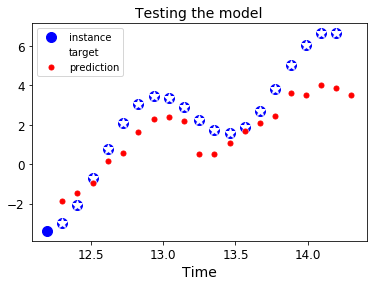

In [13]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()
# 残念ながらこのケースではDropoutは役に立たない。